**В данном ноутбуке представлен процесс подбора промптов для задачи когортного отбора пациентов для клинических исследований с результатами работы получившихся моделей.**

Петрова П.Д.

# Prerequisites

In [ ]:
!pip install langchain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.8/872.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 4.4 MB/s eta 0:00:00


In [ ]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.docstore.document import Document
from langchain.prompts import PromptTemplate
from langchain.indexes.vectorstore import VectorstoreIndexCreator
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain.chains import SequentialChain

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
TOKEN = #необходимо добавить ключ OpenAI

# Прямой запрос

## Простой запрос
В данном блоке тестируются простые запросы к модели на получение ответа ДА/НЕТ на вопрос, подходит ли пациент под указанные критерии.

На вход модели модаются тексты критериев и медицинские записи. Тексты предварительно никак не изменяются.

Промпт прямого вопроса к языковой модели:

In [ ]:
strict_forward = """Read the clinical trial criteria provided below. After that, decide by the patient's medical record if the patient is suitable for the trial. Answer YES or NO only.  


Clinical Trial Criteria: {trial}


Medical Record: {record}


Answer:"""

PROMPT = PromptTemplate(
    template=strict_forward, input_variables=["trial", "record"]
)

Промпт прямого вопроса с просьбой объяснить причину выбора ответа:

In [ ]:
strict_forward2 = """Read the clinical trial criteria provided below. After that decide by the patient medical record if the patient is suitable for the trial. Answer with YES or NO and explain why.  

Clinical Trial Criteria: {trial}

Medical Record: {record}

Answer:"""
PROMPT2 = PromptTemplate(
    template=strict_forward2, input_variables=["trial", "record"])

Модель chain для ответа только на YES/NO.

Параметры: max_tokens = 1 для ответа одним токеном (только YES/NO); temperature = 0 для избежания случайных результатов.

In [ ]:
llm = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1, temperature=0)
chain = LLMChain(llm=llm, prompt=PROMPT)

Модель chain2 для ответа на YES/NO с объяснением ответа.

Параметры: max_tokens = 100 для развернутого ответа; n = 2 для выбора лучшего результата из двух предсказанных.

In [ ]:
llm2 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=100, n=2)
chain2 = LLMChain(llm=llm2, prompt=PROMPT2)

Пробные данные критерии-запись для подбора формулировки промпта:

In [ ]:
med_trial = '''DISEASE CHARACTERISTICS: Prior or current diagnosis of any pediatric cancer Current chemoradiotherapy (at least 2 months since start of therapy) OR At least 1 year since prior treatment and in remission PATIENT CHARACTERISTICS: Age: 8 to 20 Performance status: Not specified Life expectancy: Not specified Hematopoietic: Not specified Hepatic: Not specified Renal: Not specified PRIOR CONCURRENT THERAPY: Biologic therapy: Not specified Chemotherapy: See Disease Characteristics Endocrine therapy: Not specified Radiotherapy: See Disease Characteristics Surgery: Not specified
'''
med_record = '''HISTORY: , The patient is a 15-year-old female who was seen in consultation at the request of Dr. X on 05/15/2008 regarding enlarged tonsils. The patient has been having difficult time with having two to three bouts of tonsillitis this year. She does average about four bouts of tonsillitis per year for the past several years. She notes that throat pain and fever with the actual infections. She is having no difficulty with swallowing. She does have loud snoring, though there have been no witnessed observed sleep apnea episodes. She is a mouth breather at nighttime, however. The patient does feel that she has a cold at today's visit. She has had tonsil problems again for many years. She does note a history of intermittent hoarseness as well. This is particularly prominent with the current cold that she has had. She had been seen by Dr. Y in Muskegon who had also recommended a tonsillectomy, but she reports she would like to get the surgery done here in the Ludington area as this is much closer to home. For the two tonsillitis, she is on antibiotics again on an average about four times per year. They do seem to help with the infections, but they tend to continue to recur. The patient presents today for further workup, evaluation, and treatment of the above-listed symptoms.,REVIEW OF SYSTEMS:,ALLERGY/IMMUNOLOGIC: Negative.,CARDIOVASCULAR: Negative.,PULMONARY: Negative.,GASTROINTESTINAL: Negative.,GENITOURINARY: Negative.,NEUROLOGIC: Negative.,VISUAL: Negative.,DERMATOLOGIC: Negative.,ENDOCRINE: Negative.,MUSCULOSKELETAL: Negative.,CONSTITUTIONAL: Negative.,PAST SURGICAL HISTORY: , Pertinent for previous cholecystectomy.,FAMILY HISTORY:, No family history of bleeding disorder. She does have a sister with a current ear infection. There is a family history of cancer, diabetes, heart disease, and hypertension.,CURRENT MEDICATIONS: , None.,ALLERGIES: , She has no known drug allergies.,SOCIAL HISTORY: , The patient is single. She is a student. Denies tobacco or alcohol use.,PHYSICAL EXAMINATION: ,VITAL SIGNS: Pulse is 80 and regular, temperature 98.4, weight is 184 pounds.,GENERAL: The patient is an alert, cooperative, obese, 15-year-old female, with a normal-sounding voice and good memory.,HEAD & FACE: Inspected with no scars, lesions or masses noted. Sinuses palpated and are normal. Salivary glands also palpated and are normal with no masses noted. The patient also has full facial function.,CARDIOVASCULAR: Heart regular rate and rhythm without murmur.,RESPIRATORY: Lungs auscultated and noted to be clear to auscultation bilaterally with no wheezing or rubs and normal respiratory effort.,EYES: Extraocular muscles were tested and within normal limits.,EARS: The external ears are normal. The ear canals are clean and dry. The drums are intact and mobile. Hearing is grossly normal. Tuning fork examination with normal speech reception thresholds noted.,NASAL: She has clear drainage, large inferior turbinates, no erythema.,ORAL: Her tongue, lip, floor of mouth are noted to be normal. Oropharynx does reveal very large tonsils measuring 3+/4+; they were exophytic. Mirror examination of the larynx reveals some mild edema of the larynx at this time. The nasopharynx could not be visualized on mirror exam today.,NECK: Obese, supple. Trachea is midline. Thyroid is nonpalpable.,NEUROLOGIC: Cranial nerves II through XII evaluated and noted to be normal. Patient oriented times 3.,DERMATOLOGIC: Evaluation reveals no masses or lesions. Skin turgor is normal.,IMPRESSION: , ,1. Chronic adenotonsillitis with adenotonsillar hypertrophy.,2. Upper respiratory tract infection with mild acute laryngitis.,3. Obesity.,RECOMMENDATIONS: , We are going to go ahead and proceed with an adenotonsillectomy. All risks, benefits, and alternatives regarding the surgery have been reviewed in detail with the patient and her family. This includes risk of bleeding, infection, scarring, regrowth of the adenotonsillar tissue, need for further surgery, persistent sore throat, voice changes, etc. The parents are agreeable to the planned procedure, and we will schedule this accordingly at Memorial Medical Center here within the next few weeks. We will make further recommendations afterwards.'''

In [ ]:
answer = chain.run({'trial': med_trial, 'record': med_record})
print(answer)

NO


Второй блок пробных данных для подбора.

Проверка объяснения выбор результата.

In [ ]:
med_trial2 = '''Physician diagnosis of asthma; moderate severity (1997 criteria), ie. >= 2 ED visits or 1
        hospitalization in past year or prescribed daily asthma medication.
gender All
minimum_age 6 Years
maximum_age 26 Years
healthy_volunteers No
'''
med_record2 = '''SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa was erythematous and swollen.  Only clear drainage was seen.  TMs were clear.,Neck:  Supple without adenopathy.,Lungs:  Clear.,ASSESSMENT:,  Allergic rhinitis.,PLAN:,1.  She will try Zyrtec instead of Allegra again.  Another option will be to use loratadine.  She does not think she has prescription coverage so that might be cheaper.,2.  Samples of Nasonex two sprays in each nostril given for three weeks.  A prescription was written as well.'''

In [ ]:
print(chain.run({'trial': med_trial2, 'record': med_record2}))

NO


In [ ]:
print(chain2.run({'trial': med_trial2, 'record': med_record2}))

NO. The patient has asthma but does not require daily medication for it. The clinical trial criteria state that the patient must have a physician diagnosis of asthma and prescribed


По медицинской записи понятно, что у пациентки есть астма (*She does have asthma*), поэтому по неполному объяснению модели не понятно, действительно ли он исключил пациентку по критерию отсутствия диагноза астмы.

Проверка чуть измененных критериев из прошлого примера и новой медицинской записи.

In [ ]:
med_trial3 = '''Physician diagnosis of asthma; moderate severity, ie. >= 2 ED visits or 1
        hospitalization in past year or prescribed asthma medication.
gender All
minimum_age 6 Years
maximum_age 26 Years
healthy volunteers: No
'''

In [ ]:
med_record3 = '''HISTORY OF PRESENT ILLNESS:,  The patient is a 17-year-old female, who presents to the emergency room with foreign body and airway compromise and was taken to the operating room.  She was intubated and fishbone.,PAST MEDICAL HISTORY: , Significant for diabetes, hypertension, asthma, cholecystectomy, and total hysterectomy and cataract.,ALLERGIES:  ,No known drug allergies.,
CURRENT MEDICATIONS: , Prevacid, Humulin, Diprivan, Proventil, Unasyn, and Solu-Medrol.,FAMILY HISTORY: , Noncontributory.,SOCIAL HISTORY: , Negative for illicit drugs, alcohol, and tobacco.,PHYSICAL EXAMINATION:  ,Please see the hospital chart.,LABORATORY DATA: , Please see the hospital chart.,HOSPITAL COURSE: , The patient was taken to the operating room by Dr. X who is covering for ENT and noted that she had airway compromise and a rather large fishbone noted and that was removed.  The patient was intubated and it was felt that she should be observed to see if the airway would improve upon which she could be extubated.  If not she would require tracheostomy.  The patient was treated with IV antibiotics and ventilatory support and at the time of this dictation, she has recently been taken to the operating room where it was felt that the airway sufficient and she was extubated.  She was doing well with good p.o.s, good airway, good voice, and desiring to be discharged home.  So, the patient is being prepared for discharge at this point.  We will have Dr. X evaluate her before she leaves to make sure I do not have any problem with her going home.  Dr. Y feels she could be discharged today and will have her return to see him in a week.'''

In [ ]:
print(chain2.run({'trial': med_trial3, 'record': med_record3}))

NO. The patient has a physician diagnosis of asthma, but the severity is not specified in the medical record. There is also no mention of the patient having >= 2 ED visits or 1 hospitalization in the past year or being prescribed asthma medication, which are the criteria for moderate severity asthma. Additionally, the patient has a history of diabetes, hypertension, and other surgeries, indicating a complex medical history. Therefore, the patient is not suitable for the clinical trial.


На самом же деле тяжесть астмы по критериям из текста исследования указана в медицинской записи. В списке принимаемых медикаментов указано лекарство Proventil. Проверим, знает ли модель показания для таких лекарств.

Помимо этого в критериях не указаны такие исключающие факторы как диабет, высокое давление и прочие критерии, по которым модель исключила пациентку. Это может говорить о том, что модель додумывает новую информацию сверх указанной.

In [ ]:
drug = 'Prevacid, Humulin, Diprivan, Proventil, Unasyn, and Solu-Medrol'

In [ ]:
llm3 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=100, n=2)

In [ ]:
drug_question = """For every drug in the list write for which diseases it is used: {drugs}.

Answer:"""
PROMPT3 = PromptTemplate(
    template=drug_question, input_variables=['drugs'])
chain3 = LLMChain(llm=llm3, prompt=PROMPT3)

In [ ]:
print(chain3.run({'drugs': drug}))

Prevacid is used for acid reflux and ulcers, Humulin is used for diabetes, Diprivan is used for anesthesia during surgery, Proventil is used for asthma, Unasyn is used for bacterial infections, and Solu-Medrol is used for inflammation and autoimmune disorders.


То есть модель знает, какие лекарства для чего используются, но не учел это при анализе критериев исследования и анализе медицинской записи.

Можно говорить о том, что модель плохо понимает и структурирует тексты в свободной форме.

# Запрос по критериям

В данном блоке тестируются промпты для составления списков критериев для дальнейшего анализа каждого из критериев отдельно.

In [ ]:
llm4 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1500, n=2)

In [ ]:
criteria_question = """List all criterias for the clinical trial. Then read the medical record.
After each point of the criteria list write '-YES-' if the patient falls under this criteria, or write '-NO-' if the patiend does not fall under this criteria.  

Clinical Trial: {trial}.

Medical Record: {record}

Answer:"""
PROMPT4 = PromptTemplate(
    template=criteria_question, input_variables=['trial', 'record'])
chain4 = LLMChain(llm=llm4, prompt=PROMPT4)

In [ ]:
med_trial3 = '''Physician diagnosis of asthma; moderate severity, ie. >= 2 ED visits or 1
        hospitalization in past year or prescribed daily asthma medication.
gender All
minimum_age 6 Years
maximum_age 26 Years
healthy volunteers: No
'''

In [ ]:
med_record3 = '''HISTORY OF PRESENT ILLNESS:,  The patient is a 17-year-old female, who presents to the emergency room with foreign body and airway compromise and was taken to the operating room.  She was intubated and fishbone.,PAST MEDICAL HISTORY: , Significant for diabetes, hypertension, asthma, cholecystectomy, and total hysterectomy and cataract.,ALLERGIES:  ,No known drug allergies.,
CURRENT MEDICATIONS: , Prevacid, Humulin, Diprivan, Proventil, Unasyn, and Solu-Medrol.,FAMILY HISTORY: , Noncontributory.,SOCIAL HISTORY: , Negative for illicit drugs, alcohol, and tobacco.,PHYSICAL EXAMINATION:  ,Please see the hospital chart.,LABORATORY DATA: , Please see the hospital chart.,HOSPITAL COURSE: , The patient was taken to the operating room by Dr. X who is covering for ENT and noted that she had airway compromise and a rather large fishbone noted and that was removed.  The patient was intubated and it was felt that she should be observed to see if the airway would improve upon which she could be extubated.  If not she would require tracheostomy.  The patient was treated with IV antibiotics and ventilatory support and at the time of this dictation, she has recently been taken to the operating room where it was felt that the airway sufficient and she was extubated.  She was doing well with good p.o.s, good airway, good voice, and desiring to be discharged home.  So, the patient is being prepared for discharge at this point.  We will have Dr. X evaluate her before she leaves to make sure I do not have any problem with her going home.  Dr. Y feels she could be discharged today and will have her return to see him in a week.'''

In [ ]:
print(chain4.run({'trial': med_trial3, 'record': med_record3}))

-YES- Physician diagnosis of asthma; moderate severity, ie. >= 2 ED visits or 1 hospitalization in past year or prescribed daily asthma medication.
-YES- gender: All
-NO- The patient is older than 26 years.
-NO- healthy_volunteers: No (the patient has a medical history)


Список критериев был составлен, а также были даны ответы согласно заданной форме. Однако ответы были даны до каждого из пунктов, а не после.

С фактологической стороны ответы неправильные, так как пациентке 17 лет, а в критерии указано, что ей больше 26. То же самое и с пунктом про здоровых пациентов: неправильно задан ответ, так как для испытаний как раз не нужны здоровые пациенты.

Немного переформулированный запрос на составление списка критериев и оценки каждого пункта на тех же данных.

In [ ]:
llm5 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1500, n=3)

In [ ]:
criteria_question2 = """List all criterias for the clinical trial.
After each point of the list write '-YES-' if the patient falls under this criteria, or write '-NO-' if the patient does not fall under this criteria.  

Clinical Trial: {trial}.

Medical Record: {record}

Answer:"""
PROMPT5 = PromptTemplate(
    template=criteria_question2, input_variables=['trial', 'record'])
chain5 = LLMChain(llm=llm5, prompt=PROMPT5)

In [ ]:
print(chain5.run({'trial': med_trial3, 'record': med_record3}))

-YES- for physician diagnosis of asthma; moderate severity, ie. >= 2 ED visits or 1 hospitalization in past year or prescribed daily asthma medication.
-NO- for gender (not specified in the medical record)
-NO- for minimum age (patient is 17 years old)
-NO- for maximum age (patient is 17 years old)
-NO- for healthy volunteers (not applicable to the medical record)


Гендер и возраст указаны в медицинской записи, но модель не может корректно распознать эти демографические данные пациента. Предположительно это связано с разницей понимания понятий гендер/пол, а непонимание диапазона возраста может быть связано с употреблением слов minimum/maximum age.

Проверим способность модели составлять структурированные списки критериев без ответа на вопрос.

In [ ]:
criteria_question3 = """List all criterias for the clinical trial.

Clinical Trial: {trial}.
"""
PROMPT6 = PromptTemplate(
    template=criteria_question3, input_variables=['trial'])
chain6 = LLMChain(llm=llm5, prompt=PROMPT6)

In [ ]:
print(chain6.run({'trial': med_trial3, 'record': med_record3}))

- Physician diagnosis of asthma
- Moderate severity of asthma, defined as:
  - >= 2 emergency department visits in the past year OR
  - 1 hospitalization in the past year OR
  - Prescribed daily asthma medication
- All genders
- Minimum age of 6 years
- Maximum age of 26 years
- Exclusion of healthy volunteers


Модель способна формировать корректные списки критериев, и в отличие от предыдущих примеров, когда в промптах требовался ответ после каждого пункта, в данном ответе они выписаны в правильном понимании: тяжесть болезни перечислена критериями через союз ИЛИ; указано, что все гендеры допустимы для исследования: указано, что здоровые пациенты исключаются из исследования.

Проверим возможность модели отвечать на общий вопрос о сопоставимости записи и критериев:

Необходимо составить список критериев, оценить каждый ДА/НЕТ в зависимости от того, подходит ли пациент под критерий, и если все ответы ДА, то в итоге надо вывести один ДА. Если есть хотя бы один ответ НЕТ -- вывести НЕТ.

Проверим такой промпт на новых данных.

In [ ]:
med_tr = '''Inclusion Criteria: Must meet one of the following criteria: - Overweight - Previous knee injury or surgery - Knee pain during the past year. Participants do not need to have current knee pain to take part in the study. - Parent or sibling who had knee replacement Exclusion Criteria: - Rheumatoid arthritis - Joint replacements in both knees - Unable to walk without assistance - Unable to undergo MRI of the knee'''
med_rec = '''CHIEF COMPLAINT: , Left knee pain and stiffness.,HISTORY OF PRESENT ILLNESS: , The patient is a 57-year-old with severe bilateral knee DJD, left greater than right, with significant pain and limitations because of both.  He is able to walk approximately a 1/2-mile a day but is limited because of his knees.  Stairs are negotiated 1 at a time.  His problems with bilateral knee DJD have been well documented.  He had arthroscopy in the 1991/199two time frame for both of these.  He has been on long-standing conservative course for these including nonsteroidals, narcotics, injections.  At this point because of his progressive and persistent limitations he has opted for total joint surgery on the left side.  He does have other arthritic complaints including multiple back surgeries for spinal stenosis including decompression and epidural steroids.  Significant pain is handled by narcotic medication.  His attending physician is Dr. X.,PAST MEDICAL HISTORY: , Hypertension.,PRIOR SURGERIES:,1.  Inguinal hernia on the left.,2.  Baker's cyst.,3.  Colon cancer removal.,4.  Bilateral knee scopes.,5.  Right groin hernia.,6.  Low back surgery for spinal stenosis.,7.  Status post colon cancer second surgery.,MEDICATIONS:,1.  Ambien 12.5 mg nightly.,2.  Methadone 10 mg b.i.d.,3.  Lisinopril 10 mg daily.,IV MEDICATIONS FOR PAIN:  ,Demerol appears to work the best.,ALLERGIES: , Levaquin and Cipro cause rashes; ibuprofen causes his throat to swell, Fortaz causes an unknown reaction.,REVIEW OF SYSTEMS:  ,He does have paresthesias down into his thighs secondary to spinal stenosis.,SOCIAL HISTORY: , Married.  He is retired, being a Pepsi-Cola driver secondary to his back and knees.,HABITS: , No tobacco or alcohol.  Chewed until 2003.,RECREATIONAL PURSUITS:  ,Golfs, gardens, woodworks.,FAMILY HISTORY:,1.  Cancer.,2.  Coronary artery disease.,PHYSICAL EXAMINATION:,GENERAL APPEARANCE:  A pleasant, cooperative 57-year-old white male.,VITAL SIGNS:  Height 5' 9", weight 167.  Blood pressure 148/86.  Pulse 78 per minute and regular.,HEENT:  Unremarkable.  Extraocular movements are full.  Cranial nerves II-XII intact.,NECK:  Supple.,CHEST:  Clear.,CARDIOVASCULAR:  Regular rhythm.  Normal S1 and 2.,ABDOMEN:  No organomegaly.  No tenderness.  Normal bowel sounds.,NEUROLOGIC:  Intact.,MUSCULOSKELETAL:  Left knee reveals a range of -10 degrees extension, 126 flexion.  His extensor mechanism is intact.  There is mild varus.  He has good stability at 30 degrees of flexion.  Lachman's and posterior drawer are negative.  He has good muscle turgor.  Dorsalis pedis pulse 2+.,DIAGNOSTICS:  ,X-rays revealed severe bilateral knee DJD with joint space narrowing medially as well as the patellofemoral joint with large osteophytes, left greater than right.,IMPRESSION:,1.  Bilateral knee degenerative joint disease.,2.  Significant back pain, status post lumbar stenosis surgery with pain being controlled on methadone 10 mg b.i.d.'''

In [ ]:
llm = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=300, n=2, temperature=0)

In [ ]:
criteria_list = """List all criterias for the clinical trial.
After each point of the list write 'YES' if the patient is suitable for the criteria, or write 'NO' if the patient is not suitable for this criteria.  
If there are all 'YES', print 'YES' in the end. If there is at least one 'NO', print 'NO'.

Clinical Trial: {trial}.

Medical Record: {record}

Answer:"""
PROMPT = PromptTemplate(
    template=criteria_list, input_variables=['trial', 'record'])
chain = LLMChain(llm=llm, prompt=PROMPT)

In [ ]:
print(chain.run({'trial': med_tr, 'record': med_rec}))

Inclusion Criteria:
- Overweight: YES
- Previous knee injury or surgery: YES
- Knee pain during the past year: YES
- Parent or sibling who had knee replacement: YES

Exclusion Criteria:
- Rheumatoid arthritis: YES
- Joint replacements in both knees: YES
- Unable to walk without assistance: NO
- Unable to undergo MRI of the knee: NO

Overall: YES


Так как в промпте не указано, какой нам ответ нужен (только ДА или НЕТ), мы получаем список критериев с ответами.

Т.к. список не однородный, то есть есть и включающие критерии, и исключающие, мы не можем оценивать общий ответ ДА или НЕТ, т.к. включающие критерии должны быть все ДА, а исключающие -- все НЕТ.

Ограничим способности модели к генерации новой информации за счет предложений *Print only 'YES' or 'NO' for the overall score. Do not print anything else.* и ограничения токенов до 2.

In [ ]:
llm2 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=2, n=2)

In [ ]:
criteria_list = """Get all criterias for the clinical trial.
Tag each point of the list as 'YES' if the patient is suitable for the criteria, or tag it as 'NO' if the patient is not suitable for this criteria.  
If there are all 'YES', print 'YES'. If there is at least one 'NO', print 'NO'.
Print only 'YES' or 'NO' for the overall score. Do not print anything else.

Clinical Trial: {trial}.

Medical Record: {record}

Answer:"""
PROMPT = PromptTemplate(
    template=criteria_list, input_variables=['trial', 'record'])
chain = LLMChain(llm=llm2, prompt=PROMPT)

In [ ]:
print(chain.run({'trial': med_tr, 'record': med_rec}))

- Over


Похоже, что модель начала ответ с *Overall*, но ей не хватило количества токенов.

## Цепочка промптов

Разделим большую задачу оценивания сопоставимости медицинских записей и указанных критериев на три подзадачи:



*   Разделение текста критериев исследования на список.
*   Оценивание соответствия пациента каждому из критериев (каждому из подпунктов получившегося на предыдущем шаге списка)
*   Общая оценка по результатам прошлого шага.

Каждую задачу будет выполнять собственная модель с определенным промптом.





Тестовые тексты критериев и записи:

In [ ]:
med_tr = '''Inclusion Criteria: Must meet one of the following criteria: - Overweight - Previous knee injury or surgery - Knee pain during the past year. Participants do not need to have current knee pain to take part in the study. - Parent or sibling who had knee replacement Exclusion Criteria: - Rheumatoid arthritis - Joint replacements in both knees - Unable to walk without assistance - Unable to undergo MRI of the knee'''
med_rec = '''CHIEF COMPLAINT: , Left knee pain and stiffness.,HISTORY OF PRESENT ILLNESS: , The patient is a 57-year-old with severe bilateral knee DJD, left greater than right, with significant pain and limitations because of both.  He is able to walk on his own.  Stairs are negotiated 1 at a time.  His problems with bilateral knee DJD have been well documented.  He had arthroscopy in the 1991/199two time frame for both of these.  He has been on long-standing conservative course for these including nonsteroidals, narcotics, injections.  At this point because of his progressive and persistent limitations he has opted for total joint surgery on the left side.  He does have other arthritic complaints including multiple back surgeries for spinal stenosis including decompression and epidural steroids.  Significant pain is handled by narcotic medication.  His attending physician is Dr. X.,PAST MEDICAL HISTORY: , Hypertension.,PRIOR SURGERIES:,1.  Inguinal hernia on the left.,2.  Baker's cyst.,3.  Colon cancer removal.,4.  Bilateral knee scopes.,5.  Right groin hernia.,6.  Low back surgery for spinal stenosis.,7.  Status post colon cancer second surgery.,MEDICATIONS:,1.  Ambien 12.5 mg nightly.,2.  Methadone 10 mg b.i.d.,3.  Lisinopril 10 mg daily.,IV MEDICATIONS FOR PAIN:  ,Demerol appears to work the best.,ALLERGIES: , Levaquin and Cipro cause rashes; ibuprofen causes his throat to swell, Fortaz causes an unknown reaction.,REVIEW OF SYSTEMS:  ,He does have paresthesias down into his thighs secondary to spinal stenosis.,SOCIAL HISTORY: , Married.  He is retired, being a Pepsi-Cola driver secondary to his back and knees.,HABITS: , No tobacco or alcohol.  Chewed until 2003.,RECREATIONAL PURSUITS:  ,Golfs, gardens, woodworks.,FAMILY HISTORY:,1.  Cancer.,2.  Coronary artery disease.,PHYSICAL EXAMINATION:,GENERAL APPEARANCE:  A pleasant, cooperative 57-year-old white male.,VITAL SIGNS:  Height 5' 9", weight 167.  Blood pressure 148/86.  Pulse 78 per minute and regular.,HEENT:  Unremarkable.  Extraocular movements are full.  Cranial nerves II-XII intact.,NECK:  Supple.,CHEST:  Clear.,CARDIOVASCULAR:  Regular rhythm.  Normal S1 and 2.,ABDOMEN:  No organomegaly.  No tenderness.  Normal bowel sounds.,NEUROLOGIC:  Intact.,MUSCULOSKELETAL:  Left knee reveals a range of -10 degrees extension, 126 flexion.  His extensor mechanism is intact.  There is mild varus.  He has good stability at 30 degrees of flexion.  Lachman's and posterior drawer are negative.  He has good muscle turgor.  Dorsalis pedis pulse 2+.,DIAGNOSTICS:  ,X-rays revealed severe bilateral knee DJD with joint space narrowing medially as well as the patellofemoral joint with large osteophytes, left greater than right.,IMPRESSION:,1.  Bilateral knee degenerative joint disease.,2.  Significant back pain, status post lumbar stenosis surgery with pain being controlled on methadone 10 mg b.i.d.'''

Промпт для определения списка критериев и работа данной модели на представленных текстовых примерах.

Весь список необходимо унифицировать, чтобы не допускать возможности генерации новых формулировок текста моделью, потому как это может привести к ошибкам в выстроенном алгоритме:

In [ ]:
llm1 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1500, n=2)
criteria_list = """Print all criteria from the given clinical trial as one list with points. Start each point with 'Must'.
Example:
  - Must be between 15 and 25 years old.
  - Must not have HIV.
  - Must not be pregnant.


Clinical Trial: {trial}.

List of criteria:"""
PROMPT1 = PromptTemplate(
    template=criteria_list, input_variables=['trial'])
chain = LLMChain(llm=llm1, prompt=PROMPT1, output_key='criteria_list')

In [ ]:
criteria = chain.run({'trial': med_tr})

In [ ]:
print(criteria)

- Must meet one of the following inclusion criteria: overweight, previous knee injury or surgery, knee pain during the past year, parent or sibling who had knee replacement
- Must not have rheumatoid arthritis
- Must not have joint replacements in both knees
- Must be able to walk without assistance
- Must be able to undergo MRI of the knee


Промпт для оценивания каждого из пункта списка и пример работы на тестовых текстах.

Для более точной оценки каждого из пунктов были составлены соответствующие правила, которые также ограничивают модель в ответе UNKNOWN (в случае, если модель не может получить из медицинской записи какую-либо информацию). Также в правилах опишем работу модели при перечислении критериев через союзы И/ИЛИ.

In [ ]:
llm2 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1500, n=1)
yes_no_list = """Given the medical record and the criteria list, for each criterion of the list print YES if the patient fits the criterion, or print NO if the patient does not fit the criterion.
Follow these rules:
  1. If any disease from the criterion is not mentioned in the medical record, the patient does not have it.
  2. If the activity from the criterion is not mentioned in the medical record, the patient does not have any limitations to perform it.
  3. If the point starts with 'Must', the patient must fall under the criterion.
  4. If the point starts with 'Must not', the patient must fall under the criterion.
  5. If the criterion lists some points with 'or', the patient must fall under at least one criterion from the list.
  6. If the criterion lists some points with 'and', the patient must fall under all criteria from the list.

Criteria List: {criteria_list}.
Medical Record: {record}

List of YES and NO:"""
PROMPT2 = PromptTemplate(
    template=yes_no_list, input_variables=['criteria_list', 'record'])
chain2 = LLMChain(llm=llm2, prompt=PROMPT2, output_key='tagged_list')

In [ ]:
yes_nos = chain2.run({'trial': criteria, 'record': med_rec})

In [ ]:
print(yes_nos)

- Must meet one of the following inclusion criteria: overweight, previous knee injury or surgery, knee pain during the past year, parent or sibling who had knee replacement - YES (previous knee injury or surgery, knee pain during the past year)
- Must not have rheumatoid arthritis - YES
- Must not have joint replacements in both knees - YES
- Must be able to walk without assistance - YES
- Must be able to undergo MRI of the knee. - YES


Общая оценка по полученному списку:

In [ ]:
llm3 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1, temperature=1)
yes_no_answer = """Read the criteria list with YES or NO tags.
If the tags are all YES, print YES only. If there is at least one NO, print NO only.

Criteria List: {tagged_list}

Answer:"""
PROMPT3 = PromptTemplate(
    template=yes_no_answer, input_variables=['tagged_list'])
chain3 = LLMChain(llm=llm3, prompt=PROMPT3, output_key='answer')

In [ ]:
answer = chain3.run({'list': yes_nos})

In [ ]:
answer

'YES'

Запишем в одну последовательную цепочку получившиеся промпты. Каждый элемент цепочки будет получать текст, созданный с помощью предыдущего промпта. 

После работы всей цепочки мы ожидаем один ответ: YES/NO.

In [ ]:
from langchain.chains import SequentialChain

In [ ]:
overall_chain = SequentialChain(
    chains=[chain, chain2, chain3],
    input_variables=["trial", "record"],
    # Here we return our variable
    output_variables=["answer"])

Пример работы цепочки на представленных выше тестовых текстах:

In [ ]:
result = overall_chain.run({'trial': med_tr, 'record': med_rec})

In [ ]:
print(result)

YES


#Модели с предобработкой

При работе с промптами обнаружились основные проблемы анализа текстов:

*   Сложности в определении гендера пациента.
*   Сложности в определении возрастного диапазона, указанного в критериях.

Также были обнаружены разные метрики для записи роста и веса (американские и европейские стандарты), поэтому необходимо их унифицировать: перевести в килограммы и метры.




## Предварительная обработка + прямой вопрос

In [ ]:
med_tr = '''Inclusion Criteria: Must meet one of the following criteria: - Overweight - Previous knee injury or surgery - Knee pain during the past year. Participants do not need to have current knee pain to take part in the study. - Parent or sibling who had knee replacement Exclusion Criteria: - Rheumatoid arthritis - Joint replacements in both knees - Unable to walk without assistance - Unable to undergo MRI of the knee'''
med_rec = '''CHIEF COMPLAINT: , Left knee pain and stiffness.,HISTORY OF PRESENT ILLNESS: , The patient is a 57-year-old with severe bilateral knee DJD, left greater than right, with significant pain and limitations because of both.  He is able to walk on his own.  Stairs are negotiated 1 at a time.  His problems with bilateral knee DJD have been well documented.  He had arthroscopy in the 1991/199two time frame for both of these.  He has been on long-standing conservative course for these including nonsteroidals, narcotics, injections.  At this point because of his progressive and persistent limitations he has opted for total joint surgery on the left side.  He does have other arthritic complaints including multiple back surgeries for spinal stenosis including decompression and epidural steroids.  Significant pain is handled by narcotic medication.  His attending physician is Dr. X.,PAST MEDICAL HISTORY: , Hypertension.,PRIOR SURGERIES:,1.  Inguinal hernia on the left.,2.  Baker's cyst.,3.  Colon cancer removal.,4.  Bilateral knee scopes.,5.  Right groin hernia.,6.  Low back surgery for spinal stenosis.,7.  Status post colon cancer second surgery.,MEDICATIONS:,1.  Ambien 12.5 mg nightly.,2.  Methadone 10 mg b.i.d.,3.  Lisinopril 10 mg daily.,IV MEDICATIONS FOR PAIN:  ,Demerol appears to work the best.,ALLERGIES: , Levaquin and Cipro cause rashes; ibuprofen causes his throat to swell, Fortaz causes an unknown reaction.,REVIEW OF SYSTEMS:  ,He does have paresthesias down into his thighs secondary to spinal stenosis.,SOCIAL HISTORY: , Married.  He is retired, being a Pepsi-Cola driver secondary to his back and knees.,HABITS: , No tobacco or alcohol.  Chewed until 2003.,RECREATIONAL PURSUITS:  ,Golfs, gardens, woodworks.,FAMILY HISTORY:,1.  Cancer.,2.  Coronary artery disease.,PHYSICAL EXAMINATION:,GENERAL APPEARANCE:  A pleasant, cooperative 57-year-old white male.,VITAL SIGNS:  Height 5' 9", weight 167.  Blood pressure 148/86.  Pulse 78 per minute and regular.,HEENT:  Unremarkable.  Extraocular movements are full.  Cranial nerves II-XII intact.,NECK:  Supple.,CHEST:  Clear.,CARDIOVASCULAR:  Regular rhythm.  Normal S1 and 2.,ABDOMEN:  No organomegaly.  No tenderness.  Normal bowel sounds.,NEUROLOGIC:  Intact.,MUSCULOSKELETAL:  Left knee reveals a range of -10 degrees extension, 126 flexion.  His extensor mechanism is intact.  There is mild varus.  He has good stability at 30 degrees of flexion.  Lachman's and posterior drawer are negative.  He has good muscle turgor.  Dorsalis pedis pulse 2+.,DIAGNOSTICS:  ,X-rays revealed severe bilateral knee DJD with joint space narrowing medially as well as the patellofemoral joint with large osteophytes, left greater than right.,IMPRESSION:,1.  Bilateral knee degenerative joint disease.,2.  Significant back pain, status post lumbar stenosis surgery with pain being controlled on methadone 10 mg b.i.d.'''

### Обработка критериев

В текстах критериев были обозначены трудности в понимании возрастного диапазона при их указании как миинимальный/максимальный возраст, так что пропишем отдельные правила для их определения по схеме "От X до Y лет", где X - минимальный возраст, Y - максимальный.

Гендерный критерий приведем к критерию по отбору по полу.

Пропишем правила для перевода веса в килограммы и роста в метры.

Ограничим возможность модели генерировать новую информацию правилом *Do not generate new information*, а также укажем, что каждое из указанных правил должно быть применено только в том случае, если указанный критерий есть в тексте.

In [ ]:
llm4 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1500, n=2)
trial_preprocess = """Rewrite and print the clinical trial text following the next rules:
1. If there is an age criterion:
1.1 If there is a minimum and maximum age, rewrite the age criterion as 'Age: x-y years old', where x is the minimum age and y is the maximum age.
1.2 If there is no minimum age, rewrite the age criterion as 'Age: 0-x years old', where x is the maximum age.
1.3 If there is no maximum age, rewrite the age criterion as 'Age: x and older', where x is the minimum age
2. If there is a gender criterion, rename gender criterion to sex criterion.
3. If there is a weight criterion, convert weight to kilograms.
4. If there is a height criterion, convert height to meters.
5. Do not generate new information.

Clinical Trial Text: {trial}
Result:"""
PROMPT4 = PromptTemplate(
    template=trial_preprocess, input_variables=['trial'])
chain4 = LLMChain(llm=llm4, prompt=PROMPT4, output_key='preprocessed_trial')

Пример работы промпта на тексте, указанном в предыдущем блоке:

In [ ]:
trial_text = chain4.run({'trial': med_tr})

In [ ]:
trial_text

'Inclusion Criteria: Must meet one of the following criteria: \n- Overweight \n- Previous knee injury or surgery \n- Knee pain during the past year. Participants do not need to have current knee pain to take part in the study. \n- Parent or sibling who had knee replacement \n\nAge: Not specified \nSex criterion: Not specified \nWeight criterion: Not specified \nHeight criterion: Not specified \n\nExclusion Criteria: \n- Rheumatoid arthritis \n- Joint replacements in both knees \n- Unable to walk without assistance \n- Unable to undergo MRI of the knee'

Пример работы промпта без ограничения генерации новой информации на тексте, указанном в предыдущем блоке. Некоторая информация была придумана моделью.

(исходная формулировка промпта была перезаписана)

In [ ]:
#без условий "if there is..."

'Inclusion Criteria: Must meet one of the following criteria: \n- Overweight \n- Previous knee injury or surgery \n- Knee pain during the past year. Participants do not need to have current knee pain to take part in the study. \n- Parent or sibling who had knee replacement \n\nSex: Both males and females \n\nAge: 18 and older \n\nWeight: Participants must have a body mass index (BMI) greater than or equal to 25 kg/m² \n\nHeight: Participants must be at least 1.50 meters tall \n\nExclusion Criteria: \n- Rheumatoid arthritis \n- Joint replacements in both knees \n- Unable to walk without assistance \n- Unable to undergo MRI of the knee'

### Обработка записи

Обработка записи не нуждается в изменении информации о гендере и возрасте, так что оставим только правила перевода веса и роста.

In [ ]:
llm5 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1500, n=2)
record_preprocess = """Rewrite and print the medical record text following the next rules:
1. If the patient's weight is mentioned, convert weight to kilograms.
2. If the patient's height is mentioned, convert height to meters.
3. Do not generate new information.

Medical Record Text: {record}
Result:"""
PROMPT5 = PromptTemplate(
    template=record_preprocess, input_variables=['record'])
chain5 = LLMChain(llm=llm5, prompt=PROMPT5, output_key='preprocessed_record')

Пример работы промпта на тексте, указанном в предыдущем блоке:

In [ ]:
record_text = chain5.run({'record': med_rec})

In [ ]:
record_text

"CHIEF COMPLAINT: Left knee pain and stiffness.\n\nHISTORY OF PRESENT ILLNESS: The patient is a 57-year-old with severe bilateral knee DJD, left greater than right, with significant pain and limitations because of both. He is able to walk on his own. Stairs are negotiated 1 at a time. His problems with bilateral knee DJD have been well documented. He had arthroscopy in the 1991/199two time frame for both of these. He has been on long-standing conservative course for these including nonsteroidals, narcotics, injections. At this point because of his progressive and persistent limitations he has opted for total joint surgery on the left side. He does have other arthritic complaints including multiple back surgeries for spinal stenosis including decompression and epidural steroids. Significant pain is handled by narcotic medication. His attending physician is Dr. X.\n\nPAST MEDICAL HISTORY: Hypertension.\n\nPRIOR SURGERIES:\n1. Inguinal hernia on the left.\n2. Baker's cyst.\n3. Colon cance

### Получение цепочки





Основной запрос к модели в данном промпте остается такой же, как и при простой модели с прямым запросом, однако на вход подаются тексты, предварительно обработанные соответствующими промптами. Таким образом, получается цепочка промптов.

In [ ]:
strict_forward = """Read the clinical trial criteria provided below. After that, decide by the patient's medical record if the patient is suitable for the trial. Answer YES or NO only.  

Clinical Trial Criteria: {preprocessed_trial}

Medical Record: {preprocessed_record}

Answer:"""
simplePROMPT = PromptTemplate(
    template=strict_forward, input_variables=["preprocessed_trial", "preprocessed_record"]
)
llm0 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1, temperature=0)
simple_chain = LLMChain(llm=llm0, prompt=simplePROMPT, output_key='answer')

In [ ]:
overall_simple = SequentialChain(
    chains=[chain4, chain5, simple_chain],
    input_variables=["trial", "record"],
    # Here we return our variable
    output_variables=["answer"])

## Предобработка + запрос по критериям

В случае со сложной моделью цепочки, в которой составляется список критериев, тексты обрабатываются теми же промптами, что указаны в предыдущем блоке, и затем обработанные тексты подаются в цепочку, описанную в блоке "Запрос по критериям"

In [ ]:
llm4 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1500, n=2)
trial_preprocess = """Rewrite and print the clinical trial text following the next rules:
1. If there is an age criterion:
1.1 If there is a minimum and maximum age, rewrite the age criterion as 'Age: x-y years old', where x is the minimum age and y is the maximum age.
1.2 If there is no minimum age, rewrite the age criterion as 'Age: 0-x years old', where x is the maximum age.
1.3 If there is no maximum age, rewrite the age criterion as 'Age: x and older', where x is the minimum age
2. If there is a gender criterion, rename gender criterion to sex criterion.
3. If there is a weight criterion, convert weight to kilograms.
4. If there is a height criterion, convert height to meters.
5. Do not generate new information.

Clinical Trial Text: {trial}
Result:"""
PROMPT4 = PromptTemplate(
    template=trial_preprocess, input_variables=['trial'])
chain4 = LLMChain(llm=llm4, prompt=PROMPT4, output_key='preprocessed_trial')

In [ ]:
llm5 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1500, n=2)
record_preprocess = """Rewrite and print the medical record text following the next rules:
1. If the patient's weight is mentioned, convert weight to kilograms.
2. If the patient's height is mentioned, convert height to meters.
3. Do not generate new information.

Medical Record Text: {record}
Result:"""
PROMPT5 = PromptTemplate(
    template=record_preprocess, input_variables=['record'])
chain5 = LLMChain(llm=llm5, prompt=PROMPT5, output_key='preprocessed_record')

In [ ]:
llm1 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1500, n=2)
criteria_list = """Print all criteria for the given clinical trial as one list with points. Start each point with 'Must'.
Example:
  - Must be between 15 and 25 years old.
  - Must not have HIV.
  - Must not be pregnant.


Clinical Trial: {preprocessed_trial}.

List of criteria:"""
PROMPT1 = PromptTemplate(
    template=criteria_list, input_variables=['preprocessed_trial'])
chain = LLMChain(llm=llm1, prompt=PROMPT1, output_key='criteria_list')

In [ ]:
llm2 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=150, n=1)
yes_no_list = """Given the medical record and the criteria list, for each criterion of the list print YES if the patient is suitable for the criterion, or print NO if the patient is not suitable for the criterion.
Follow these rules:
  1. If any disease from the criterion is not mentioned in the medical record, the patient does not have it.
  2. If the activity from the criterion is not mentioned in the medical record, the patient does not have any limitations to perform it. 
  3. If the point starts with 'Must', the patient must fall under the criterion.
  4. If the point starts with 'Must not', the patient must fall under the criterion.
  5. If the criterion lists some points with 'or', the patient must fall under at least one criterion from the list.
  6. If the criterion lists some points with 'and', the patient must fall under all criteria from the list.

Criteria List: {criteria_list}.
Medical Record: {preprocessed_record}

List of YES and NO:"""
PROMPT2 = PromptTemplate(
    template=yes_no_list, input_variables=['criteria_list', 'preprocessed_record'])
chain2 = LLMChain(llm=llm2, prompt=PROMPT2, output_key='tagged_list')

In [ ]:
llm3 = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1, n=1)
yes_no_answer = """Read the criteria list with YES or NO tags. 
If the tags are all YES, print YES only. If there is at least one NO, print NO only.

Criteria List: {tagged_list}

Answer:"""
PROMPT3 = PromptTemplate(
    template=yes_no_answer, input_variables=['tagged_list'])
chain3 = LLMChain(llm=llm3, prompt=PROMPT3, output_key='answer')

In [ ]:
overall_chain_preprocessed = SequentialChain(
    chains=[chain4, chain5, chain, chain2, chain3],
    input_variables=["trial", "record"],
    # Here we return our variable
    output_variables=["answer"])

# Тестирование на датасете

Проверим работу полученных моделей на датасете из текстов критериев исследований и медицинских записей, каждая пара которых оценена как YES/NO по критерию подходимости пациента из записи под указанные критерии

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/mag diplom/final dataset.xlsx')

In [ ]:
df

,Clinical Trial,Medical Sample,Suitability
0,DISEASE CHARACTERISTICS: \n- Prior or current ...,HISTORY: The patient is a 5-1/2-year-old with...,NO
1,DISEASE CHARACTERISTICS: \n- Prior or current ...,"INTERVAL HISTORY:, ABC who is 10 years of age ...",NO
2,DISEASE CHARACTERISTICS: \n- Prior or current ...,"DIAGNOSIS: , T1 N3 M0 cancer of the nasopharyn...",NO
3,DISEASE CHARACTERISTICS: \n- Prior or current ...,The patient states that she has been doing fai...,NO
4,DISEASE CHARACTERISTICS: \n- Prior or current ...,"HISTORY: , The patient is a 15-year-old female...",NO
...,...,...,...
95,Inclusion Criteria:\n\n - Males and ...,SUBJECTIVE: 10-year old male. School reports ...,YES
96,Inclusion criteria\n - Patients with...,"HISTORY:, The patient, female, 53 years-old, ...",YES
97,Inclusion criteria\n - Patients with...,"INDICATIONS: ,Chest pain, hypertension, type ...",YES
98,Inclusion criteria\n - Patients with...,"HISTORY OF PRESENT ILLNESS: , The patient is a...",YES


Датасет состоит из 100 вхождений, метки сбалансированы:

In [ ]:
df.Suitability.value_counts()

NO     50
YES    50
Name: Suitability, dtype: int64

## Тестирование модели с прямым запросом

In [ ]:
import time

Из подобранных моделей в блоке "Прямой запрос" выберем следующую формулировку промпта:

In [ ]:
strict_forward = """Read the clinical trial criteria provided below. After that, decide by the patient's medical record if the patient is suitable for the trial. Answer YES or NO only.  

Clinical Trial Criteria: {trial}

Medical Record: {record}

Answer:"""
PROMPT = PromptTemplate(
    template=strict_forward, input_variables=["trial", "record"]
)

In [ ]:
llm = ChatOpenAI(openai_api_key=TOKEN, model_name="gpt-3.5-turbo", max_tokens=1, temperature=0)
chain = LLMChain(llm=llm, prompt=PROMPT)

In [ ]:
y_pred = []

In [ ]:
for i in range(100):
  answer = chain.run({'trial': df['Clinical Trial'][i], 'record': df['Medical Sample'][i]})
  y_pred.append(answer)
  time.sleep(50)


In [ ]:
len(y_pred)

100

In [ ]:
confusion_matrix(list(df['Suitability']), y_pred)

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 1,  0, 42,  7],
       [ 1,  1, 22, 26]])

Так как в предсказанных метках присутствуют значения, отличные от YES и NO, заменим такие ответы на NO, чтобы не было возможных некорректных меток YES

In [ ]:
y_changed_pred = []
for i in y_pred:
  if i != 'YES' and i != 'NO':
    y_changed_pred.append('NO')
  else:
    y_changed_pred.append(i)

In [ ]:
tn, fp, fn, tp = confusion_matrix(df['Suitability'], y_changed_pred).ravel()
(tn, fp, fn, tp)  

(43, 7, 24, 26)

In [ ]:
print(classification_report(df['Suitability'], y_changed_pred))

              precision    recall  f1-score   support

          NO       0.64      0.86      0.74        50
         YES       0.79      0.52      0.63        50

    accuracy                           0.69       100
   macro avg       0.71      0.69      0.68       100
weighted avg       0.71      0.69      0.68       100



## Тестирование простой модели с предобработкой

In [ ]:
y_pred_preproc = []

Для тестирования была выбрана цепочка overall_simple, представленная в блоке "Предварительная обработка + прямой запрос"

In [ ]:
for i in range(100):
  answer = overall_simple.run({'trial': df['Clinical Trial'][i], 'record': df['Medical Sample'][i]})
  y_pred_preproc.append(answer)
  time.sleep(60)

In [ ]:
len(y_pred_preproc)

100

In [ ]:
y_changed_pred = []
for i in y_pred_preproc:
  if i != 'YES' and i != 'NO':
    y_changed_pred.append('NO')
  else:
    y_changed_pred.append(i)

In [ ]:
tn, fp, fn, tp = confusion_matrix(df['Suitability'], y_changed_pred).ravel()
(tn, fp, fn, tp) 

(42, 8, 27, 23)

In [ ]:
print(classification_report(df['Suitability'], y_changed_pred))

              precision    recall  f1-score   support

          NO       0.61      0.84      0.71        50
         YES       0.74      0.46      0.57        50

    accuracy                           0.65       100
   macro avg       0.68      0.65      0.64       100
weighted avg       0.68      0.65      0.64       100



## Тестирование сложной модели

In [ ]:
import time

In [ ]:
y_pred_complex = []

Для тестирования выберем модель overall_chain, представленную в блоке "Запрос по критериям":

In [ ]:
for i in range(100):
  answer = overall_chain.run({'trial': df['Clinical Trial'][i], 'record': df['Medical Sample'][i]})
  y_pred_complex.append(answer)
  time.sleep(50)

In [ ]:
len(y_pred_complex)

100

In [ ]:
y_changed_pred = []
for i in y_pred_complex:
  if i != 'YES' and i != 'NO':
    y_changed_pred.append('NO')
  else:
    y_changed_pred.append(i)

In [ ]:
tn, fp, fn, tp = confusion_matrix(df['Suitability'], y_changed_pred).ravel()
(tn, fp, fn, tp)

(48, 2, 36, 14)

In [ ]:
print(classification_report(df['Suitability'], y_changed_pred))

              precision    recall  f1-score   support

          NO       0.57      0.96      0.72        50
         YES       0.88      0.28      0.42        50

    accuracy                           0.62       100
   macro avg       0.72      0.62      0.57       100
weighted avg       0.72      0.62      0.57       100



## Тестирование сложной модели с предобработкой

In [ ]:
import time

In [ ]:
y_pred_complex_preproc = []

В качестве модели выберем цепочку overall_chain_preprocessed, представленную в блоке "Предобработка + запрос по критериям"

In [ ]:
for i in range(100):
  answer = overall_chain_preprocessed.run({'trial': df['Clinical Trial'][i], 'record': df['Medical Sample'][i]})
  y_pred_complex_preproc.append(answer)
  time.sleep(60)

In [ ]:
len(y_pred_complex_preproc)

100

In [ ]:
y_changed_pred = []
for i in y_pred_complex_preproc:
  if i != 'YES' and i != 'NO':
    y_changed_pred.append('NO')
  else:
    y_changed_pred.append(i)

In [ ]:
tn, fp, fn, tp = confusion_matrix(df['Suitability'], y_changed_pred).ravel()
(tn, fp, fn, tp)

(47, 3, 31, 19)

In [ ]:
print(classification_report(df['Suitability'], y_changed_pred))

              precision    recall  f1-score   support

          NO       0.60      0.94      0.73        50
         YES       0.86      0.38      0.53        50

    accuracy                           0.66       100
   macro avg       0.73      0.66      0.63       100
weighted avg       0.73      0.66      0.63       100



## Голосование

В качестве пятой модели составим систему голосования, которая будет отбирать ответ исходя их ответов четырех представленных выше моделей. Если результат YES будет представлен более 50%, что в нашей случае составляет 3 или 4 раза, то итоговый ответ будет YES. Иначе -- NO.

Так как мы уже имеем полученные ответы предыдущих моделей, поместим их в такую систему голосования.

In [ ]:
voting_system = []
general = []
for i in range(100):
  general.append([y_pred[i], y_pred_preproc[i], y_pred_complex[i], y_pred_complex_preproc[i]])

for k in general:
  num = k.count('YES')
  if num > 2:
    voting_system.append('YES')
  else:
    voting_system.append('NO')

In [ ]:
voting_system

In [ ]:
print(classification_report(df['Suitability'], voting_system))

              precision    recall  f1-score   support

          NO       0.59      0.98      0.74        50
         YES       0.94      0.32      0.48        50

    accuracy                           0.65       100
   macro avg       0.77      0.65      0.61       100
weighted avg       0.77      0.65      0.61       100



In [ ]:
tn, fp, fn, tp = confusion_matrix(df['Suitability'], voting_system).ravel()
(tn, fp, fn, tp)

(49, 1, 34, 16)

# ROC-кривая

Чтобы оценить наиболее удачную модель, поместим их результаты на ROC-кривую, где ось X - False Positive Rate (FPR), ось Y - True Positive Rate (TPR), посчитанные по следующим формулам:

TPR = TP/(TP+FN)

FPR = FP/(FP+TN)

In [ ]:
# Данные по самой простой модели
(tn, fp, fn, tp) = (43, 7, 24, 26)
simp_tpr = tp/(tp+fn) 
simp_fpr = fp/(fp+tn)
print(simp_tpr, simp_fpr)

0.52 0.14


In [ ]:
#Данные по простой + препроцессинг
(tn, fp, fn, tp) = (42, 8, 27, 23)
simp_prep_tpr = tp/(tp+fn) 
simp_prep_fpr = fp/(fp+tn)
print(simp_prep_tpr, simp_prep_fpr)

0.46 0.16


In [ ]:
#Данные по сложной 
(tn, fp, fn, tp) = (48, 2, 36, 14)
complex_tpr = tp/(tp+fn) 
complex_fpr = fp/(fp+tn)
print(complex_tpr, complex_fpr)

0.28 0.04


In [ ]:
#Данные по сложной + препроцессинг
(tn, fp, fn, tp) = (47, 3, 31, 19)
complex_prep_tpr = tp/(tp+fn) 
complex_prep_fpr = fp/(fp+tn)
print(complex_prep_tpr, complex_prep_fpr)

0.38 0.06


In [ ]:
#Данные по голосованию
(tn, fp, fn, tp) = (49, 1, 34, 16)
voting_tpr = tp/(tp+fn) 
voting_fpr = fp/(fp+tn)
print(voting_tpr, voting_fpr)

0.32 0.02


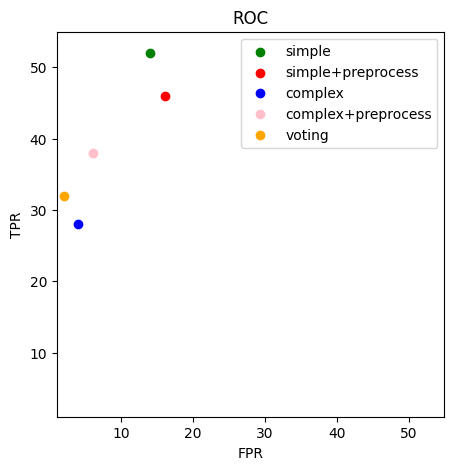

In [ ]:
import matplotlib.pyplot as plt
  
# x axis values
y = [ i * 100 for i in [simp_tpr, simp_prep_tpr, complex_tpr, complex_prep_tpr, voting_tpr]]
# corresponding y axis values
x = [ i * 100 for i in [simp_fpr, simp_prep_fpr, complex_fpr, complex_prep_fpr, voting_fpr]]
label= ['simple', 'simple+preprocess', 'complex', 'complex+preprocess', 'voting']
color=["green", "red", "blue", "pink", "orange"]
  

plt.figure(figsize=(5,5))

# plotting the points 
for i in range(5):
  plt.scatter(x[i], y[i], label=label[i], color=color[i])
  
# setting x and y axis range
plt.ylim(1, 55)
plt.xlim(1, 55)
  
# naming the x axis
plt.xlabel('FPR')
# naming the y axis
plt.ylabel('TPR')

plt.legend()
  
# giving a title to my graph
plt.title('ROC')
  
# function to show the plot
plt.show()

Если оценивать модели по полученному графу, то наиболее успешной моделью кажется модель с простым запросов, указанная на графике зеленым цветом.